In [1]:
from datetime import datetime
import numpy as np
import pickle
import json

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/SPARSe

/content/gdrive/.shortcut-targets-by-id/1hNRRb9O7Y1kI_ulnKgi3KeD8eRwFsiwr/SPARSe


In [ ]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.0
    Uninstalling SQLAlchemy-2.0.0:
      Successfully uninstalled SQLAlchemy-2.0.0


In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [5]:
donations = pd.read_csv("./data/donations.csv")

In [6]:
projects = pd.read_csv("./data/projects.csv")

In [7]:
len(projects)

664098

In [8]:
projects_donations_df = projects.merge(donations, on='projectid', how='left')

In [9]:
projects_donations_df['date_posted'] = projects_donations_df.date_posted.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [10]:
projects_donations_df['deadline'] = projects_donations_df['date_posted'] + pd.DateOffset(months=4)

In [11]:
# Filter to donations before deadline
projects_donations_filtered_df = projects_donations_df[projects_donations_df.donation_timestamp <= projects_donations_df.deadline]

In [12]:
print(len(projects_donations_df), len(projects_donations_filtered_df))

3237045 2894222


In [13]:
funded_amt_df = projects_donations_filtered_df.groupby('projectid')['donation_to_project'].sum().reset_index(name='funded_amt')

In [14]:
funding_frac_df = projects.merge(funded_amt_df, on='projectid', how='left')[['projectid', 'funded_amt', 'total_price_excluding_optional_support']].fillna(0.0)

In [15]:
funding_frac_df['funding_frac'] = funding_frac_df.funded_amt / funding_frac_df.total_price_excluding_optional_support

In [16]:
funding_frac_df = funding_frac_df.fillna(1.0)

In [17]:
funding_frac_df.replace([np.inf, -np.inf], 1.0, inplace=True)

In [18]:
funding_frac_df

,projectid,funded_amt,total_price_excluding_optional_support,funding_frac
0,316ed8fb3b81402ff6ac8f721bb31192,0.0,555.81,0.000000
1,90de744e368a7e4883223ca49318ae30,0.0,296.47,0.000000
2,32943bb1063267de6ed19fc0ceb4b9a7,0.0,430.89,0.000000
3,bb18f409abda2f264d5acda8cab577a9,0.0,576.07,0.000000
4,24761b686e18e5eace634607acbcc19f,0.0,408.40,0.000000
...,...,...,...,...
664093,a7236ea96c812895cafc5d700d779147,254.0,231.00,1.099567
664094,e02da37beb332eb66c2d2ba989c597ad,1241.0,1129.00,1.099203
664095,82e536f14eadf2671a70e03416f695a3,125.0,125.00,1.000000
664096,e139df754a873a62d93daa56acbf8040,125.0,125.00,1.000000


In [19]:
projects_donations_filtered_df.date_posted

44772     2013-12-31
44773     2013-12-31
44774     2013-12-31
44775     2013-12-31
44776     2013-12-31
             ...    
3237040   2002-09-17
3237041   2002-09-17
3237042   2002-09-16
3237043   2002-09-13
3237044   2002-09-13
Name: date_posted, Length: 2894222, dtype: datetime64[ns]

In [21]:
projects_donations_filtered_df['date_posted_plus_4_weeks'] = projects_donations_filtered_df['date_posted'] + pd.DateOffset(weeks=4)

<ipython-input-21-fbf891ceee70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_donations_filtered_df['date_posted_plus_4_weeks'] = projects_donations_filtered_df['date_posted'] + pd.DateOffset(weeks=4)


In [22]:
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d +  pd.DateOffset(days=days_ahead)

In [23]:
projects_donations_filtered_df['evaluation_date'] = projects_donations_filtered_df.date_posted_plus_4_weeks.apply(lambda x: next_weekday(x, 0))

<ipython-input-23-58a8144bdacc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_donations_filtered_df['evaluation_date'] = projects_donations_filtered_df.date_posted_plus_4_weeks.apply(lambda x: next_weekday(x, 0))


In [24]:
projects_donations_filtered_df[['date_posted', 'date_posted_plus_4_weeks', 'evaluation_date']]

,date_posted,date_posted_plus_4_weeks,evaluation_date
44772,2013-12-31,2014-01-28,2014-02-03
44773,2013-12-31,2014-01-28,2014-02-03
44774,2013-12-31,2014-01-28,2014-02-03
44775,2013-12-31,2014-01-28,2014-02-03
44776,2013-12-31,2014-01-28,2014-02-03
...,...,...,...
3237040,2002-09-17,2002-10-15,2002-10-21
3237041,2002-09-17,2002-10-15,2002-10-21
3237042,2002-09-16,2002-10-14,2002-10-21
3237043,2002-09-13,2002-10-11,2002-10-14


In [25]:
valid_projects_donations_filtered_df = projects_donations_filtered_df[projects_donations_filtered_df.donation_timestamp < projects_donations_filtered_df.evaluation_date]

In [26]:
funded_amt_by_evaluation_df = valid_projects_donations_filtered_df.groupby('projectid')['donation_to_project'].sum().reset_index(name='funded_amt_by_evaluation_date')

In [27]:
projects['date_posted'] = projects.date_posted.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
projects['date_posted_plus_4_weeks'] = projects['date_posted'] + pd.DateOffset(weeks=4)

In [28]:
projects['evaluation_date'] = projects.date_posted_plus_4_weeks.apply(lambda x: next_weekday(x, 0))

In [29]:
baseline_df = projects[['projectid', 'evaluation_date', 'poverty_level', 'eligible_double_your_impact_match']].merge(funding_frac_df, on='projectid', how='inner').merge(funded_amt_by_evaluation_df, on='projectid', how='left')

In [30]:
baseline_df.funded_amt_by_evaluation_date = baseline_df.funded_amt_by_evaluation_date.fillna(0.0)

In [31]:
baseline_df['is_fully_funded'] = baseline_df.funding_frac >= 1.0

In [32]:
baseline_df['funding_frac_by_evaluation_date'] = baseline_df['funded_amt_by_evaluation_date'] / baseline_df['total_price_excluding_optional_support']

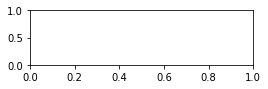

In [33]:
baseline_df.funding_frac_by_evaluation_date = baseline_df.funding_frac_by_evaluation_date.fillna(1.0)

In [34]:
baseline_df.funding_frac_by_evaluation_date.replace([np.inf, -np.inf], 1.0, inplace=True)

In [35]:
set(baseline_df.poverty_level.values)

{'high poverty', 'highest poverty', 'low poverty', 'moderate poverty'}

In [40]:
def poverty_rank(poverty_level, funding_frac_by_evaluation_date):
  if poverty_level == "moderate poverty":
    level = 0
  elif poverty_level == "high poverty":
    level = 1
  elif poverty_level == "low poverty":
    level = 2
  elif poverty_level == "highest poverty":
    level = 3
  return 100.0*level + funding_frac_by_evaluation_date

In [41]:
baseline_df.tail(1)

,projectid,evaluation_date,poverty_level,eligible_double_your_impact_match,funded_amt,total_price_excluding_optional_support,funding_frac,funded_amt_by_evaluation_date,is_fully_funded,funding_frac_by_evaluation_date
664097,77558a6eda151deee9a00553f7fccfc7,2002-10-14,highest poverty,f,229.0,229.0,1.0,229.0,True,1.0


In [42]:
baseline_df['poverty_rank'] = baseline_df.apply(lambda x: poverty_rank(x.poverty_level, x.funding_frac_by_evaluation_date), axis=1)

In [ ]:
def eligible_double_impact_match_rank(eligible_double_your_impact_match, funding_frac_by_evaluation_date):
  if eligible_double_your_impact_match == "f":
    level = 0
  elif eligible_double_your_impact_match == "t":
    level = 1
  return 100.0*level + funding_frac_by_evaluation_date

In [ ]:
baseline_df['eligible_double_impact_match_rank'] = baseline_df.apply(lambda x: eligible_double_impact_match_rank(x.eligible_double_your_impact_match, x.funding_frac_by_evaluation_date), axis=1)

In [44]:
filtered_baseline_df = baseline_df[baseline_df.funding_frac_by_evaluation_date < 1.0]

In [45]:
poverty_ranked_baseline_df = filtered_baseline_df.sort_values("poverty_rank").head(int(len(baseline_df)*0.1))

In [46]:
1 - poverty_ranked_baseline_df.is_fully_funded.sum() / len(poverty_ranked_baseline_df.is_fully_funded)

0.6986251863452243

In [ ]:
eligible_match_ranked_baseline_df = filtered_baseline_df.sort_values("eligible_double_impact_match_rank").head(int(len(baseline_df)*0.1))

In [ ]:
1 - eligible_match_ranked_baseline_df.is_fully_funded.sum() / len(eligible_match_ranked_baseline_df.is_fully_funded)

0.7028866569290306

In [48]:
funding_frac_ranked_baseline_df = filtered_baseline_df.sort_values("funding_frac_by_evaluation_date").head(int(len(baseline_df)*0.1))

In [50]:
1 - funding_frac_ranked_baseline_df.is_fully_funded.sum() / len(funding_frac_ranked_baseline_df.is_fully_funded)

0.651116565525757

In [ ]:
train_test_val_project_ids = json.load(open('update2_baseline_3trainvalsplit-enddate_2013_11_24-10wk.json', 'r'))

In [ ]:
train_test_val_project_ids.keys()

dict_keys(['train3', 'valid3', 'test3', 'train2', 'valid2', 'test2', 'train1', 'valid1', 'test1'])

In [ ]:
val1_df = filtered_baseline_df[filtered_baseline_df.projectid.isin(train_test_val_project_ids['valid1'])]
val2_df = filtered_baseline_df[filtered_baseline_df.projectid.isin(train_test_val_project_ids['valid2'])]
val3_df = filtered_baseline_df[filtered_baseline_df.projectid.isin(train_test_val_project_ids['valid3'])]

In [ ]:
len(val1_df), len(val2_df), len(val3_df)

(8737, 11858, 24558)

In [ ]:
len(train_test_val_project_ids['valid1']), len(train_test_val_project_ids['valid2']), len(train_test_val_project_ids['valid3'])

(14822, 17098, 42447)

In [ ]:
len(train_test_val_project_ids['test1']), len(train_test_val_project_ids['test2']), len(train_test_val_project_ids['test3'])

(9020, 24832, 24116)

In [ ]:
len(train_test_val_project_ids['train1']), len(train_test_val_project_ids['train2']), len(train_test_val_project_ids['train2'])

(85409, 76631, 76631)

In [ ]:
len(filtered_baseline_df.projectid.values), len(set(filtered_baseline_df.projectid.values))

(457667, 457667)

In [ ]:
len(train_test_val_project_ids['valid1'])

14822

In [ ]:
print(f'val1, all: {1 - val1_df.is_fully_funded.sum() / len(val1_df)}')
print(f'val2, all: {1 - val2_df.is_fully_funded.sum() / len(val2_df)}')
print(f'val3, all: {1 - val3_df.is_fully_funded.sum() / len(val3_df)}')

val1, all: 0.5921941169737897
val2, all: 0.5638387586439535
val3, all: 0.48729538236012704


In [ ]:
val1_poverty_ranked_baseline_df = val1_df.sort_values("poverty_rank").head(int(len(train_test_val_project_ids['valid1'])*0.1))
val2_poverty_ranked_baseline_df = val2_df.sort_values("poverty_rank").head(int(len(train_test_val_project_ids['valid2'])*0.1))
val3_poverty_ranked_baseline_df = val3_df.sort_values("poverty_rank").head(int(len(train_test_val_project_ids['valid3'])*0.1))

In [ ]:
val1_eligible_match_ranked_baseline_df = val1_df.sort_values("eligible_double_impact_match_rank").head(int(len(train_test_val_project_ids['valid1'])*0.1))
val2_eligible_match_ranked_baseline_df = val2_df.sort_values("eligible_double_impact_match_rank").head(int(len(train_test_val_project_ids['valid2'])*0.1))
val3_eligible_match_ranked_baseline_df = val3_df.sort_values("eligible_double_impact_match_rank").head(int(len(train_test_val_project_ids['valid3'])*0.1))

In [ ]:
val1_funding_frac_baseline_df = val1_df.sort_values("funding_frac_by_evaluation_date").head(int(len(train_test_val_project_ids['valid1'])*0.1))
val2_funding_frac_baseline_df = val2_df.sort_values("funding_frac_by_evaluation_date").head(int(len(train_test_val_project_ids['valid2'])*0.1))
val3_funding_frac_baseline_df = val3_df.sort_values("funding_frac_by_evaluation_date").head(int(len(train_test_val_project_ids['valid3'])*0.1))

In [ ]:
print(f'val1, poverty: {1 - val1_poverty_ranked_baseline_df.is_fully_funded.sum() / len(val1_poverty_ranked_baseline_df.is_fully_funded)}')
print(f'val2, poverty: {1 - val2_poverty_ranked_baseline_df.is_fully_funded.sum() / len(val2_poverty_ranked_baseline_df.is_fully_funded)}')
print(f'val3, poverty: {1 - val3_poverty_ranked_baseline_df.is_fully_funded.sum() / len(val3_poverty_ranked_baseline_df.is_fully_funded)}')

val1, poverty: 0.6369770580296896
val2, poverty: 0.6108835576360445
val3, poverty: 0.47337417530631476


In [ ]:
print(f'val1, eligible: {1 - val1_eligible_match_ranked_baseline_df.is_fully_funded.sum() / len(val1_eligible_match_ranked_baseline_df.is_fully_funded)}')
print(f'val2, eligible: {1 - val2_eligible_match_ranked_baseline_df.is_fully_funded.sum() / len(val2_eligible_match_ranked_baseline_df.is_fully_funded)}')
print(f'val3, eligible: {1 - val3_eligible_match_ranked_baseline_df.is_fully_funded.sum() / len(val3_eligible_match_ranked_baseline_df.is_fully_funded)}')

val1, eligible: 0.738191632928475
val2, eligible: 0.7337624341720304
val3, eligible: 0.5004712535344016


In [ ]:
print(f'val1, funding frac: {1 - val1_funding_frac_baseline_df.is_fully_funded.sum() / len(val1_funding_frac_baseline_df.is_fully_funded)}')
print(f'val2, funding frac: {1 - val2_funding_frac_baseline_df.is_fully_funded.sum() / len(val2_funding_frac_baseline_df.is_fully_funded)}')
print(f'val3, funding frac: {1 - val3_funding_frac_baseline_df.is_fully_funded.sum() / len(val3_funding_frac_baseline_df.is_fully_funded)}')

val1, funding frac: 0.7051282051282051
val2, funding frac: 0.665886483323581
val3, funding frac: 0.5362865221489161


In [ ]:
val1_random_baseline_df = val1_df.sample(frac=1.0).head(int(len(train_test_val_project_ids['valid1'])*0.1))
val2_random_baseline_df = val2_df.sample(frac=1.0).head(int(len(train_test_val_project_ids['valid2'])*0.1))
val3_random_baseline_df = val3_df.sample(frac=1.0).head(int(len(train_test_val_project_ids['valid3'])*0.1))

In [ ]:
print(f'val1, random: {1 - val1_random_baseline_df.is_fully_funded.sum() / len(val1_random_baseline_df.is_fully_funded)}')
print(f'val2, random: {1 - val2_random_baseline_df.is_fully_funded.sum() / len(val2_random_baseline_df.is_fully_funded)}')
print(f'val3, random: {1 - val3_random_baseline_df.is_fully_funded.sum() / len(val3_random_baseline_df.is_fully_funded)}')

val1, random: 0.6079622132253711
val2, random: 0.5874780573434757
val3, random: 0.49528746465598494


In [ ]:
filtered_baseline_df[filtered_baseline_df.projectid.isin(train_test_val_project_ids['train3'])].is_fully_funded.sum()

15322

In [ ]:
len(filtered_baseline_df[filtered_baseline_df.projectid.isin(train_test_val_project_ids['train3'])])

38374

In [ ]:
15322/38374

0.39928076301662585

In [ ]:
2798/6493

0.43092561219775144

In [ ]:
8026/14917

0.5380438425956962

In [ ]:
len(funding_frac_df[funding_frac_df.funding_frac < 1.0]) / len(funding_frac_df)

0.4489472939234872

In [ ]:
donations[donations.projectid.isin(train_test_val_project_ids['valid1'])]

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message


In [ ]:
donations[donations.projectid=='8173d3a3997b0c4c12a4d8224bf28b98']

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message


In [ ]:
min(projects[projects.projectid.isin(train_test_val_project_ids['valid1'])].date_posted), max(projects[projects.projectid.isin(train_test_val_project_ids['valid1'])].date_posted)

(Timestamp('2014-01-06 00:00:00'), Timestamp('2014-03-16 00:00:00'))

In [ ]:
min(donations.donation_timestamp), max(donations.donation_timestamp)

('2000-03-01 14:24:26', '2014-04-28 22:44:25.923')